In [1]:
import pickle
import numpy as np

from data_loader import DataLoader
from utils import millis

def load_object(filename):
    with open(filename, 'rb') as inp:
        return pickle.load(inp)

def draw_pointcloud(np_pointcloud):
    pcd = open3d.geometry.PointCloud()
    pcd.points = open3d.utility.Vector3dVector(np_pointcloud)
    open3d.visualization.draw_geometries([pcd],
                                    zoom=0.5,
                                    front=[0.5, -0.2, -1],
                                    lookat=[0, 0, 0],
                                    up=[0, -1, 0.2])

SCENE = 'redkitchen'
DATA_PATH = '../data'

params = load_object(f'params_{SCENE}.pkl')
print(f'Loading forest trained on "{SCENE}"')

[print(f'\t{key}: {params[key]}') for key in [
    'TIMESTAMP',
    'TREE_MAX_DEPTH',
    'NUM_TRAIN_IMAGES_PER_TREE',
    'NUM_SAMPLES_PER_IMAGE',
    'NUM_PARAMETER_SAMPLES']]
forest = load_object(f'trained_forest_{SCENE}.pkl')

Loading forest trained on "redkitchen"
	TIMESTAMP: 18/03/2022 21:30:57
	TREE_MAX_DEPTH: 16
	NUM_TRAIN_IMAGES_PER_TREE: 500
	NUM_SAMPLES_PER_IMAGE: 5000
	NUM_PARAMETER_SAMPLES: 1024


In [2]:
NUM_TEST_IMAGES = 200
NUM_SAMPLES_PER_IMAGE = 800

loader = DataLoader(DATA_PATH)

# Sample points from tests data
test_set_indices = params['TEST_INDICES']
test_indices = np.random.choice(test_set_indices, NUM_TEST_IMAGES, replace = False)
images_data = loader.load_dataset(SCENE, test_indices)
p_s, w_s = loader.sample_from_data_set(
    images_data = images_data,
    num_samples = NUM_SAMPLES_PER_IMAGE)

# Evalulate tree
num_samples = NUM_TEST_IMAGES * NUM_SAMPLES_PER_IMAGE
print(f'Evaluating tree for {num_samples} samples')
start = millis()

tree_predictions = forest.evaluate(p_s, images_data)
print(f'Finished after {(millis() - start):5.1F}ms')
images_data = None

Evaluating tree for 160000 samples
Finished after 39013.0ms


In [3]:
# Extract predictions
valid_predictions_tot = 0
predictions = np.ndarray((num_samples * params['NUM_TREES'], 3), dtype=np.float64)

for i, pred_s in enumerate(tree_predictions):
    valid_mask = ~np.any(pred_s == -np.inf, axis=1)
    pred_s_valid = pred_s[valid_mask]
    valid_predictions = np.sum(valid_mask)
    predictions[valid_predictions_tot:valid_predictions_tot+valid_predictions] = pred_s_valid
    valid_predictions_tot += valid_predictions

predictions = predictions[:valid_predictions_tot]

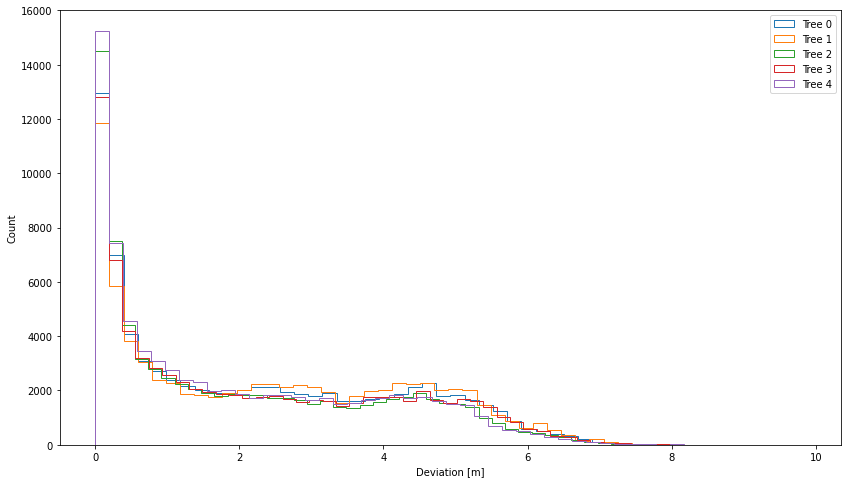

In [4]:
from matplotlib import pyplot as plt

plt.figure(figsize=(14,8))

for i, pred_s in enumerate(tree_predictions):
    valid_mask = ~np.any(pred_s == -np.inf, axis=1)
    w_s_valid = w_s[valid_mask]
    pred_s_valid = pred_s[valid_mask]

    valid_predictions = np.sum(valid_mask)
    errors = np.sum(np.abs(w_s_valid - pred_s_valid.copy()), axis=1)
    plt.hist(errors, bins=50, fill=False, histtype='step', label=f'Tree {i}')

plt.xlabel('Deviation [m]')
plt.ylabel('Count')
plt.legend()

In [5]:
tree = forest.trees[3]
nodes_by_depth = [None] * (tree.max_depth + 1)

for node_id in tree.nodes:
    node = tree.nodes[node_id]
    if nodes_by_depth[node.depth] == None:
        nodes_by_depth[node.depth] = []
    nodes_by_depth[node.depth].append(node)
    
for depth, nodes in enumerate(nodes_by_depth):
    nodes_expected = 2 ** depth
    print(f'In depth {depth:2} have {len(nodes):7} of {nodes_expected:7} nodes {len(nodes) * 100 / nodes_expected:3.2F}%')

In depth  0 have       1 of       1 nodes 100.00%
In depth  1 have       2 of       2 nodes 100.00%
In depth  2 have       4 of       4 nodes 100.00%
In depth  3 have       8 of       8 nodes 100.00%
In depth  4 have      16 of      16 nodes 100.00%
In depth  5 have      32 of      32 nodes 100.00%
In depth  6 have      64 of      64 nodes 100.00%
In depth  7 have     128 of     128 nodes 100.00%
In depth  8 have     256 of     256 nodes 100.00%
In depth  9 have     512 of     512 nodes 100.00%
In depth 10 have    1024 of    1024 nodes 100.00%
In depth 11 have    2048 of    2048 nodes 100.00%
In depth 12 have    4096 of    4096 nodes 100.00%
In depth 13 have    8192 of    8192 nodes 100.00%
In depth 14 have   16326 of   16384 nodes 99.65%
In depth 15 have   31708 of   32768 nodes 96.77%
In depth 16 have   56592 of   65536 nodes 86.35%


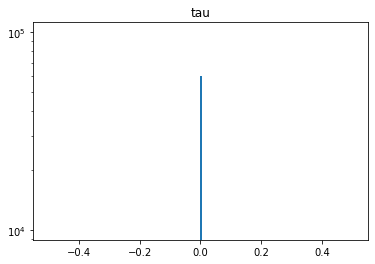

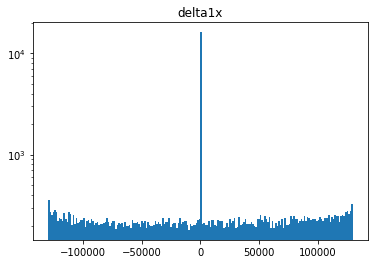

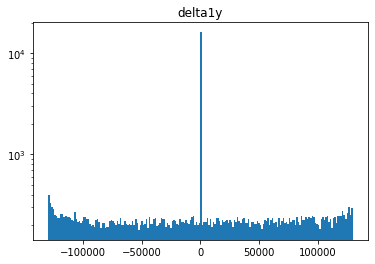

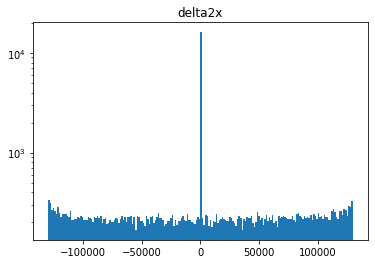

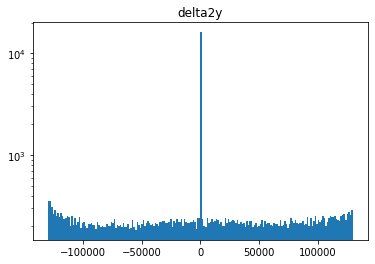

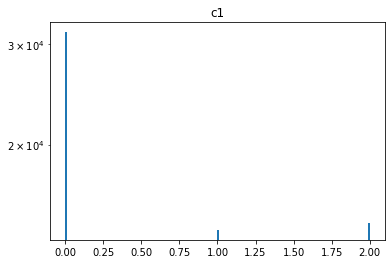

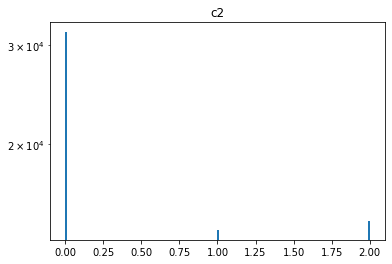

In [6]:
tree = forest.trees[0]

num_nodes = len(tree.nodes)
num_params = len(tree.nodes['0'].params)
param_names = ['tau', 'delta1x', 'delta1y', 'delta2x', 'delta2y', 'c1', 'c2']

params_all = np.ndarray((num_params, num_nodes))
num_non_leaf_nodes = 0

for i, node_id in enumerate(tree.nodes):
    node = tree.nodes[node_id]
    
    if node.node_id_left != '' and node.node_id_right != '':
        num_non_leaf_nodes += 1
        for j in range(num_params):
            params_all[j][i] = node.params[j]
            
params_all = params_all[:,:num_non_leaf_nodes]

for i, name in enumerate(param_names):
    plt.title(name)
    plt.hist(params_all[i], bins=200)
    plt.yscale('log')
    plt.show()